![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/banner_1.png)

# Proyecto 2 - Clasificación de género de películas

El propósito de este proyecto es que puedan poner en práctica, en sus respectivos grupos de trabajo, sus conocimientos sobre técnicas de preprocesamiento, modelos predictivos de NLP, y la disponibilización de modelos. Para su desarrollo tengan en cuenta las instrucciones dadas en la "Guía del proyecto 2: Clasificación de género de películas"

**Entrega**: La entrega del proyecto deberán realizarla durante la semana 8. Sin embargo, es importante que avancen en la semana 7 en el modelado del problema y en parte del informe, tal y como se les indicó en la guía.

Para hacer la entrega, deberán adjuntar el informe autocontenido en PDF a la actividad de entrega del proyecto que encontrarán en la semana 8, y subir el archivo de predicciones a la [competencia de Kaggle](https://www.kaggle.com/t/2c54d005f76747fe83f77fbf8b3ec232).

## Datos para la predicción de género en películas

En este proyecto se usará un conjunto de datos de géneros de películas. Cada observación contiene el título de una película, su año de lanzamiento, la sinopsis o plot de la película (resumen de la trama) y los géneros a los que pertenece (una película puede pertenercer a más de un género). Por ejemplo:
- Título: 'How to Be a Serial Killer'
- Plot: 'A serial killer decides to teach the secrets of his satisfying career to a video store clerk.'
- Generos: 'Comedy', 'Crime', 'Horror'

La idea es que usen estos datos para predecir la probabilidad de que una película pertenezca, dada la sinopsis, a cada uno de los géneros.

Agradecemos al profesor Fabio González, Ph.D. y a su alumno John Arevalo por proporcionar este conjunto de datos. Ver https://arxiv.org/abs/1702.01992

## Ejemplo predicción conjunto de test para envío a Kaggle
En esta sección encontrarán el formato en el que deben guardar los resultados de la predicción para que puedan subirlos a la competencia en Kaggle.

In [3]:
# Ignorar alertas
import warnings
warnings.filterwarnings('ignore')

In [4]:
# Importación librerías
import pandas as pd
import os
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import r2_score, roc_auc_score
from sklearn.model_selection import train_test_split

In [5]:
# Carga de datos de archivo .csv
dataTraining = pd.read_csv('https://github.com/albahnsen/MIAD_ML_and_NLP/raw/main/datasets/dataTraining.zip', encoding='UTF-8', index_col=0)
dataTesting = pd.read_csv('https://github.com/albahnsen/MIAD_ML_and_NLP/raw/main/datasets/dataTesting.zip', encoding='UTF-8', index_col=0)

### Análisis exploratorio de datos

In [28]:
# Visualización datos de entrenamiento
dataTraining.head()

,year,title,plot,genres,rating,genres_list,plot_clean_1
3107,2003,Most,most is the story of a single father who takes...,"['Short', 'Drama']",8.0,"[Short, Drama]",story single father take eight year old son wo...
900,2008,How to Be a Serial Killer,a serial killer decides to teach the secrets o...,"['Comedy', 'Crime', 'Horror']",5.6,"[Comedy, Crime, Horror]",serial killer decides teach secret satisfying ...
6724,1941,A Woman's Face,"in sweden , a female blackmailer with a disfi...","['Drama', 'Film-Noir', 'Thriller']",7.2,"[Drama, Film-Noir, Thriller]",sweden female blackmailer disfiguring facial s...
4704,1954,Executive Suite,"in a friday afternoon in new york , the presi...",['Drama'],7.4,[Drama],friday afternoon new york president tredway co...
2582,1990,Narrow Margin,"in los angeles , the editor of a publishing h...","['Action', 'Crime', 'Thriller']",6.6,"[Action, Crime, Thriller]",los angeles editor publishing house carol hunn...


In [29]:
# Visualización datos de test
dataTesting.head()

,year,title,plot,plot_clean_1
1,1999,Message in a Bottle,"who meets by fate , shall be sealed by fate ....",meet fate shall sealed fate theresa osborne ru...
4,1978,Midnight Express,"the true story of billy hayes , an american c...",true story billy hayes american college studen...
5,1996,Primal Fear,martin vail left the chicago da ' s office to ...,martin vail left chicago office become success...
6,1950,Crisis,husband and wife americans dr . eugene and mr...,husband wife american eugene mr helen ferguson...
7,1959,The Tingler,the coroner and scientist dr . warren chapin ...,coroner scientist warren chapin researching sh...


In [8]:
nulos = dataTraining.isnull().sum()               # Busqueda de valores nulos
duplicados = dataTraining.duplicated().sum()      # Busqueda de valores repetidos
titulos_unicos = dataTraining['title'].nunique()  # títulos únicos de películas

print(f'Valores nulos:\n{nulos}')
print(f'\nValores duplicados: {duplicados}')
print(f'\nCantidad de títulos únicos: {titulos_unicos}')

Valores nulos:
year      0
title     0
plot      0
genres    0
rating    0
dtype: int64

Valores duplicados: 1

Cantidad de títulos únicos: 7729


In [10]:
dataTraining.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7895 entries, 3107 to 215
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   year    7895 non-null   int64  
 1   title   7895 non-null   object 
 2   plot    7895 non-null   object 
 3   genres  7895 non-null   object 
 4   rating  7895 non-null   float64
dtypes: float64(1), int64(1), object(3)
memory usage: 370.1+ KB


In [33]:
# Listado de películas con títulos duplicados
dataTraining[dataTraining.duplicated(subset=['title'], keep=False)].sort_values('title')

,year,title,plot,genres,rating,genres_list,plot_clean_1
10885,1916,"20,000 Leagues Under the Sea","captain nemo has built a fantastic submarine for his mission of revenge . he has traveled over N , N leagues in search of charles denver - a man who caused the death of princess daaker . seeing what he had done , denver took the daughter to his yacht and sailed away . he abandoned her and a sailor on a mysterious island and has come back after all these years to see if she is still alive and if the nightmares he has will stop . the daughter has been found by five survivors of a union army balloon that crashed near the island . at sea , professor aronnax was aboard the ship ' abraham lincoln ' when nemo rammed it and threw the professor , his daughter and two others into the water . prisoners at first , they are now treated as guests to view the underwater world and to hunt under the waves . nemo will also tells them about the nautilus and the revenge that has driven him for all these years .","['Action', 'Adventure', 'Sci-Fi']",7.1,"[Action, Adventure, Sci-Fi]",captain nemo built fantastic submarine mission revenge traveled league search charles denver man caused death princess daaker seeing done denver took daughter yacht sailed away abandoned sailor mysterious island come back year see still alive nightmare stop daughter found five survivor union army balloon crashed near island sea professor aronnax aboard ship abraham lincoln nemo rammed threw professor daughter two others water prisoner first treated guest view underwater world hunt wave nemo also tell nautilus revenge driven year
10745,1954,"20,000 Leagues Under the Sea","in N , a monster is terrorizing the seas , sinking ships ! three unlikely companions board a warship in search of the beast , only to find out the hard way it is an engine of destruction : a submarine boat . the trio is captured by the vessel ' s commander , captain nemo , and accompany him on a journey of adventure and discovery as the nautilus and her occupants travel some N , N leagues under the sea .","['Adventure', 'Drama', 'Family', 'Fantasy', 'Sci-Fi']",7.2,"[Adventure, Drama, Family, Fantasy, Sci-Fi]",monster terrorizing sea sinking ship three unlikely companion board warship search beast find hard way engine destruction submarine boat trio captured vessel commander captain nemo accompany journey adventure discovery nautilus occupant travel league sea
9182,1957,3:10 to Yuma,"when the charming outlaw ben wade is captured after the heist of a stagecoach , the stage line owner mr . butterfield offers us$ N to the man that escorts the bandit to the city of contention to take the N : N pm train to yuma to be sent to trial . the rancher dan evans is broken and needs the money to save his cattle and support his family and accepts the assignment . during their journey , dan saves the life of ben when a vigilante tries to execute the criminal . meanwhile ben ' s gang split to find where ben is and then rescues their boss . when they find that ben is trapped in a hotel room , they put the place under siege and dan can not find any man to help him .","['Drama', 'Thriller', 'Western']",7.6,"[Drama, Thriller, Western]",charming outlaw ben wade captured heist stagecoach stage line owner butterfield offer man escort bandit city contention take train yuma sent trial rancher dan evans broken need money save cattle support family accepts assignment journey dan save life ben vigilante try execute criminal meanwhile ben gang split find ben rescue bos find ben trapped hotel room put place siege dan find man help
2583,2007,3:10 to Yuma,"rancher dan evans heads into bisbee to clear up issues concerning the sale of his land when he witnesses the closing events of a stagecoach robbery led by famed outlaw ben wade . shortly thereafter , wade is captured by the law in bisbee and evans finds himself one of the escorts who will take wade to the N : N to yuma train in contention for the reward of $ N . evans ' s effort to take 

#### Librerias

In [11]:
import pandas as pd
import nltk
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import TreebankWordTokenizer

from itertools import chain
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import ast

In [12]:
dataTraining['genres_list'] = dataTraining['genres'].apply(ast.literal_eval)

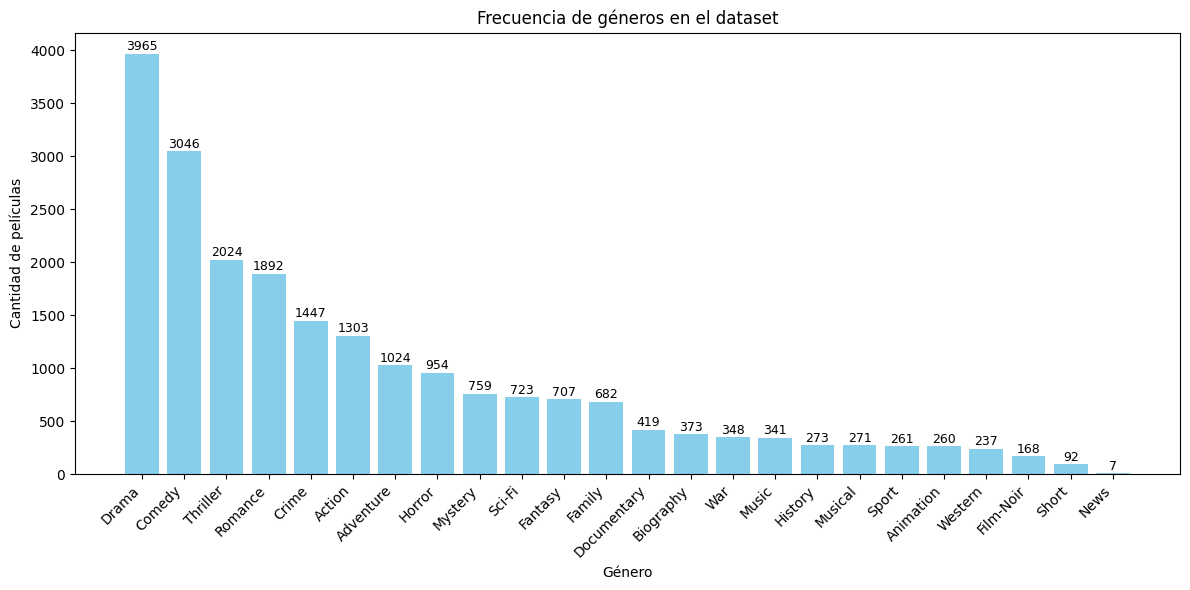

In [13]:
frecuencia_generos = list(chain.from_iterable(dataTraining['genres_list']))
# Paso 2: Contar la frecuencia de cada género
conteo_generos = Counter(frecuencia_generos)

# Paso 3: Ordenar los géneros por frecuencia
sorted_genres = conteo_generos.most_common()
genres, counts = zip(*sorted_genres)

# Paso 4: Crear el gráfico de barras
plt.figure(figsize=(12, 6))
bars = plt.bar(genres, counts, color='skyblue')
plt.xticks(rotation=45, ha='right')
plt.xlabel('Género')
plt.ylabel('Cantidad de películas')
plt.title('Frecuencia de géneros en el dataset')
plt.tight_layout()

# Paso 5: Añadir etiquetas a cada barra
for bar, count in zip(bars, counts):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 5,
             str(count), ha='center', va='bottom', fontsize=9)

plt.show()

In [14]:
# Descarga de recursos de NLTK
try:
    stopwords.words('english')
except LookupError:
    nltk.download('stopwords')
try:
    WordNetLemmatizer().lemmatize('test')
except LookupError:
    nltk.download('wordnet')
try:
    nltk.word_tokenize("example")
except LookupError:
    nltk.download('punkt')
    nltk.download('punkt_tab')

In [15]:
# Inicialización de herramientas
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

In [ ]:
# Función de preprocesamiento
def preprocess_text_1(text):
    if isinstance(text, str): # Asegurarse de que la entrada sea una cadena
        text = text.lower()
        text = re.sub(r'[^a-z\s]', '', text) # Liempieza de caracteres diferentes a letras, sustitucion por " "
        tokens = nltk.word_tokenize(text)
        tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words and len(word) > 2] # Lematización y eliminación de stopwords y palabras cortas
        return ' '.join(tokens)
    return '' # Manejar casos donde el texto no es una cadena

def preprocess_text_2(text):
    if isinstance(text, str): # Asegurarse de que la entrada sea una cadena
        text = text.lower()
        text = re.sub(r'[^a-z\s]', '', text) # Liempieza de caracteres diferentes a letras, sustitucion por " "
        tokens = nltk.word_tokenize(text)
        tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words and len(word) > 2] # Lematización y eliminación de stopwords y palabras cortas
        return ' '.join(tokens)
    return '' # Manejar casos donde el texto no es una cadena

1 = Tokenizacion sencilla y lematizacion sencilla

2 = Tokenizacion

In [ ]:
# Aplicar a los datos
dataTraining['plot_clean_1'] = dataTraining['plot'].apply(preprocess_text_1)
dataTesting['plot_clean_1'] = dataTesting['plot'].apply(preprocess_text_1)

dataTraining['plot_clean_2'] = dataTraining['plot'].apply(preprocess_text_2)
dataTesting['plot_clean_2'] = dataTesting['plot'].apply(preprocess_text_2)

In [36]:
dataTraining.head()

,year,title,plot,genres,rating,genres_list,plot_clean_1
3107,2003,Most,"most is the story of a single father who takes his eight year - old son to work with him at the railroad drawbridge where he is the bridge tender . a day before , the boy meets a woman boarding a train , a drug abuser . at the bridge , the father goes into the engine room , and tells his son to stay at the edge of the nearby lake . a ship comes , and the bridge is lifted . though it is supposed to arrive an hour later , the train happens to arrive . the son sees this , and tries to warn his father , who is not able to see this . just as the oncoming train approaches , his son falls into the drawbridge gear works while attempting to lower the bridge , leaving the father with a horrific choice . the father then lowers the bridge , the gears crushing the boy . the people in the train are completely oblivious to the fact a boy died trying to save them , other than the drug addict woman , who happened to look out her train window . the movie ends , with the man wandering a new city , and meets the woman , no longer a drug addict , holding a small baby . other relevant narratives run in parallel , namely one of the female drug - addict , and they all meet at the climax of this tumultuous film .","['Short', 'Drama']",8.0,"[Short, Drama]",story single father take eight year old son work railroad drawbridge bridge tender day boy meet woman boarding train drug abuser bridge father go engine room tell son stay edge nearby lake ship come bridge lifted though supposed arrive hour later train happens arrive son see try warn father able see oncoming train approach son fall drawbridge gear work attempting lower bridge leaving father horrific choice father lower bridge gear crushing boy people train completely oblivious fact boy died trying save drug addict woman happened look train window movie end man wandering new city meet woman longer drug addict holding small baby relevant narrative run parallel namely one female drug addict meet climax tumultuous film
900,2008,How to Be a Serial Killer,a serial killer decides to teach the secrets of his satisfying career to a video store clerk .,"['Comedy', 'Crime', 'Horror']",5.6,"[Comedy, Crime, Horror]",serial killer decides teach secret satisfying career video store clerk
6724,1941,A Woman's Face,"in sweden , a female blackmailer with a disfiguring facial scar meets a gentleman who lives beyond his means . they become accomplices in blackmail , and she falls in love with him , bitterly resigned to the impossibility of his returning her affection . her life changes when one of her victims proves to be the wife of a plastic surgeon , who catches her in his apartment , but believes her to be a jewel thief rather than a blackmailer . he offers her the chance to look like a normal woman again , and she accepts , despite the agony of multiple operations . meanwhile , her gentleman accomplice forms an evil scheme to rid himself of the one person who stands in his way to a fortune - his four - year - old - nephew .","['Drama', 'Film-Noir', 'Thriller']",7.2,"[Drama, Film-Noir, Thriller]",sweden female blackmailer disfiguring facial scar meet gentleman life beyond mean become accomplice blackmail fall love bitterly resigned impossibility returning affection life change one victim prof wife plastic surgeon catch apartment belief jewel thief rather blackmailer offer chance look like normal woman accepts despite agony multiple operation meanwhile gentleman accomplice form evil scheme rid one person stand way fortune four year old nephew
4704,1954,Executive Suite,"in a friday afternoon in new york , the president of the tredway corporation avery bullard has just had a meeting with investment bankers and sends a telegram scheduling a meeting at the furniture factory in millburgh , pennsylvania , at six pm with his executives . bullard has never appointed an executive vice - president for the corporation after the death of the previous one but 

### Multiclasificacion

In [28]:
mlb = MultiLabelBinarizer()
genre_matrix = mlb.fit_transform(dataTraining['genres_list'])

genre_labels = mlb.classes_

# Crear nuevo DataFrame con columnas binarias
import pandas as pd
genre_df = pd.DataFrame(genre_matrix, columns=genre_labels)

# Unir al dataframe original si lo deseas
dataTraining_bin = pd.concat([dataTraining.reset_index(drop=True), genre_df], axis=1)
dataTraining_bin.head()


,year,title,plot,genres,rating,genres_list,plot_clean_1,Action,Adventure,Animation,...,Musical,Mystery,News,Romance,Sci-Fi,Short,Sport,Thriller,War,Western
0,2003,Most,most is the story of a single father who takes...,"[Short, Drama]",8.0,"[Short, Drama]",story single father take eight year old son wo...,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,2008,How to Be a Serial Killer,a serial killer decides to teach the secrets o...,"[Comedy, Crime, Horror]",5.6,"[Comedy, Crime, Horror]",serial killer decides teach secret satisfying ...,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1941,A Woman's Face,"in sweden , a female blackmailer with a disfi...","[Drama, Film-Noir, Thriller]",7.2,"[Drama, Film-Noir, Thriller]",sweden female blackmailer disfiguring facial s...,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,1954,Executive Suite,"in a friday afternoon in new york , the presi...",[Drama],7.4,[Drama],friday afternoon new york president tredway co...,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1990,Narrow Margin,"in los angeles , the editor of a publishing h...","[Action, Crime, Thriller]",6.6,"[Action, Crime, Thriller]",los angeles editor publishing house carol hunn...,1,0,0,...,0,0,0,0,0,0,0,1,0,0


## Entrenamiento del modelo

In [ ]:
# Plot a utilizar
PLOT = 'plot_clean_1'

In [39]:
# Definición de variables predictoras (X)
vect = CountVectorizer(max_features=1000)
X_dtm = vect.fit_transform(dataTraining[PLOT])
X_dtm.shape

(7895, 1000)

In [40]:
# Definición de variable de interés (y)
dataTraining['genres'] = dataTraining['genres'].map(lambda x: eval(x))
le = MultiLabelBinarizer()
y_genres = le.fit_transform(dataTraining['genres'])

In [41]:
# Separación de variables predictoras (X) y variable de interés (y) en set de entrenamiento y test usandola función train_test_split
X_train, X_test, y_train_genres, y_test_genres = train_test_split(X_dtm, y_genres, test_size=0.33, random_state=42)

In [42]:
# Definición y entrenamiento
clf = OneVsRestClassifier(RandomForestClassifier(n_jobs=-1, n_estimators=100, max_depth=10, random_state=42))
clf.fit(X_train, y_train_genres)

OneVsRestClassifier(estimator=RandomForestClassifier(max_depth=10, n_jobs=-1,
                                                     random_state=42))

In [43]:
# Predicción del modelo de clasificación
y_pred_genres = clf.predict_proba(X_test)

# Impresión del desempeño del modelo
roc_auc_score(y_test_genres, y_pred_genres, average='macro')

np.float64(0.7938889824275073)

## Aplicación del modelo a datos de test

In [44]:
# transformación variables predictoras X del conjunto de test
X_test_dtm = vect.transform(dataTesting[PLOT])

cols = ['p_Action', 'p_Adventure', 'p_Animation', 'p_Biography', 'p_Comedy', 'p_Crime', 'p_Documentary', 'p_Drama', 'p_Family',
        'p_Fantasy', 'p_Film-Noir', 'p_History', 'p_Horror', 'p_Music', 'p_Musical', 'p_Mystery', 'p_News', 'p_Romance',
        'p_Sci-Fi', 'p_Short', 'p_Sport', 'p_Thriller', 'p_War', 'p_Western']

# Predicción del conjunto de test
y_pred_test_genres = clf.predict_proba(X_test_dtm)

In [45]:
# Guardar predicciones en formato exigido en la competencia de kaggle
res = pd.DataFrame(y_pred_test_genres, index=dataTesting.index, columns=cols)
res.to_csv('pred_genres_text_RF.csv', index_label='ID')
res.head()

,p_Action,p_Adventure,p_Animation,p_Biography,p_Comedy,p_Crime,p_Documentary,p_Drama,p_Family,p_Fantasy,p_Film-Noir,p_History,p_Horror,p_Music,p_Musical,p_Mystery,p_News,p_Romance,p_Sci-Fi,p_Short,p_Sport,p_Thriller,p_War,p_Western
1,0.126665,0.097757,0.032137,0.035655,0.357779,0.119925,0.081390,0.494762,0.062375,0.103420,0.011450,0.024793,0.085504,0.071438,0.024057,0.073098,0.000095,0.363867,0.053852,0.008264,0.019452,0.196768,0.022314,0.016416
4,0.126084,0.092287,0.022438,0.063351,0.310612,0.175248,0.061373,0.517114,0.061228,0.063882,0.010705,0.029241,0.085815,0.026447,0.023506,0.063599,0.000422,0.159060,0.055178,0.009446,0.018790,0.205361,0.025805,0.026196
5,0.186972,0.111627,0.018306,0.063678,0.272033,0.506304,0.062881,0.611120,0.070749,0.102553,0.066509,0.036584,0.169908,0.023130,0.027097,0.333505,0.000220,0.282433,0.065803,0.022661,0.047695,0.431198,0.053941,0.022544
6,0.134968,0.094271,0.019318,0.069481,0.342558,0.119798,0.027844,0.579294,0.089784,0.065502,0.022012,0.045035,0.092974,0.041232,0.141338,0.096687,0.000000,0.258879,0.060984,0.008240,0.022521,0.265032,0.082235,0.018470
7,0.181018,0.204829,0.036944,0.032003,0.358070,0.245908,0.041665,0.371660,0.096867,0.188146,0.011957,0.026758,0.326483,0.023846,0.033460,0.096865,0.000025,0.183116,0.368813,0.008697,0.017214,0.249744,0.022459,0.022437
